In [1]:
# Importing all librairies I need
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
import scipy.stats as scs
import scipy.linalg as scl
from statsmodels.formula.api import ols
from statsmodels.api import OLS
from statsmodels.api import add_constant
from Assumptions import Assumption_Tester_OLS as ast

In [2]:
# Loading my dataset
df=pd.read_csv('energydata_complete.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19735 entries, 0 to 19734
Data columns (total 29 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         19735 non-null  object 
 1   Appliances   19735 non-null  int64  
 2   lights       19735 non-null  int64  
 3   T1           19735 non-null  float64
 4   RH_1         19735 non-null  float64
 5   T2           19735 non-null  float64
 6   RH_2         19735 non-null  float64
 7   T3           19735 non-null  float64
 8   RH_3         19735 non-null  float64
 9   T4           19735 non-null  float64
 10  RH_4         19735 non-null  float64
 11  T5           19735 non-null  float64
 12  RH_5         19735 non-null  float64
 13  T6           19735 non-null  float64
 14  RH_6         19735 non-null  float64
 15  T7           19735 non-null  float64
 16  RH_7         19735 non-null  float64
 17  T8           19735 non-null  float64
 18  RH_8         19735 non-null  float64
 19  T9  

In [4]:
# Droping the 2 last columns, containing random variables 
df = df.drop(['rv1','rv2'], axis=1)

In [5]:
#I don't want type=object, I've to convert my column date
df.date = pd.to_datetime(df.date)

In [6]:
df.info()    # date's Dtype is now datetime

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19735 entries, 0 to 19734
Data columns (total 27 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         19735 non-null  datetime64[ns]
 1   Appliances   19735 non-null  int64         
 2   lights       19735 non-null  int64         
 3   T1           19735 non-null  float64       
 4   RH_1         19735 non-null  float64       
 5   T2           19735 non-null  float64       
 6   RH_2         19735 non-null  float64       
 7   T3           19735 non-null  float64       
 8   RH_3         19735 non-null  float64       
 9   T4           19735 non-null  float64       
 10  RH_4         19735 non-null  float64       
 11  T5           19735 non-null  float64       
 12  RH_5         19735 non-null  float64       
 13  T6           19735 non-null  float64       
 14  RH_6         19735 non-null  float64       
 15  T7           19735 non-null  float64       
 16  RH_7

In [7]:
# Let's create a new column which tells us if we're in weekend or not
df['weekday'] = df.date.dt.dayofweek
df.loc[df.weekday<=4, 'Weekend'] = 0
df.loc[df.weekday>4, 'Weekend'] = 1

<AxesSubplot:>

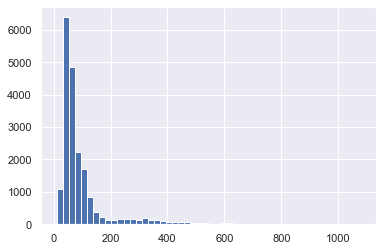

In [8]:
"""Let's see Appliance consumption column distribution"""
df.Appliances.hist(bins=50)

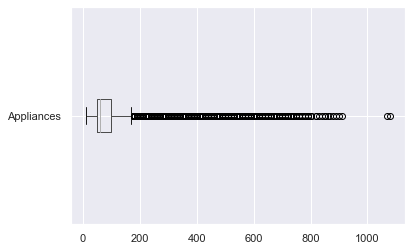

In [9]:
df.boxplot(column='Appliances', vert=False)
plt.show()

In [ ]:
# Triyng to turn the distribution into normal

Lambda value used for Transformation: -0.5308659934909413


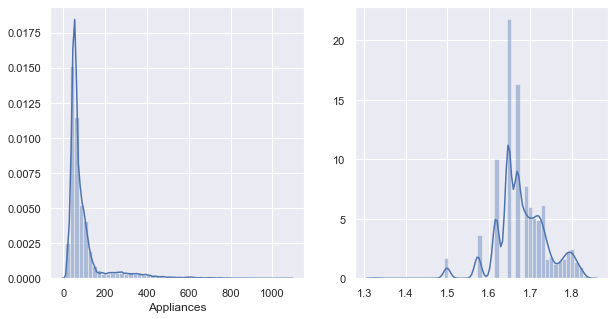

In [10]:
#Trying better distribution with boxcox
from scipy import stats
fitted_data, fitted_lambda = stats.boxcox(df.Appliances) 

fig, ax = plt.subplots(1, 2)   
sns.distplot(df.Appliances, hist = True, kde = True, ax = ax[0])   
sns.distplot(fitted_data, hist = True, kde = True, ax = ax[1]) 
fig.set_figheight(5) 
fig.set_figwidth(10)   
print(f"Lambda value used for Transformation: {fitted_lambda}") 

In [ ]:
# Boxcox does not make a beautiful normal distribution, I'll use np.log

In [11]:
df['Ap_log']= np.log(df.Appliances)

<AxesSubplot:>

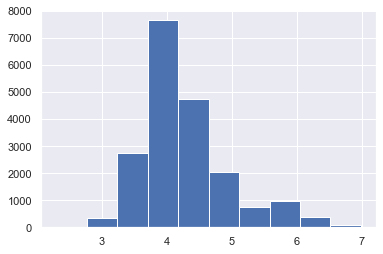

In [12]:
df.Ap_log.hist()

In [13]:
scs.norm.fit(df.Ap_log)  #Gives estimated mu and sigma

(4.3037073750233015, 0.6562901802518624)

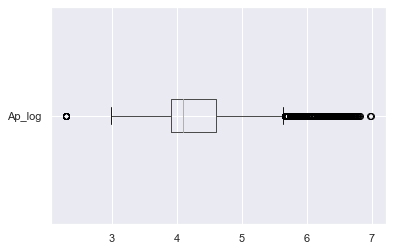

In [14]:
df.boxplot(column='Ap_log', vert=False)
plt.show()                               # It's better, I keep it

<AxesSubplot:>

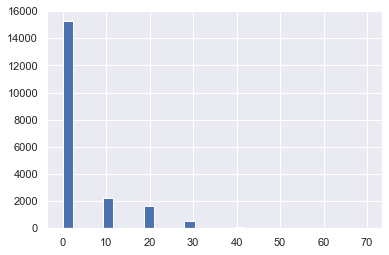

In [15]:
"""Lets see the lights column"""
df.lights.hist(bins=30) 

In [16]:
df.lights.unique()
# It's not possible to replace this log distribution by a normal one because of too many 0

array([30, 40, 50, 70, 60, 10, 20,  0], dtype=int64)

In [ ]:
"""We may consider the difference of temperature between outside and inside"""
# the greater is this difference, the more energy must be used

In [18]:
df[['T6', 'T_out', 'RH_6', 'RH_out']].describe()

,T6,T_out,RH_6,RH_out
count,19735.000000,19735.000000,19735.000000,19735.000000
mean,7.910939,7.411665,54.609083,79.750418
std,6.090347,5.317409,31.149806,14.901088
min,-6.065000,-5.000000,1.000000,24.000000
25%,3.626667,3.666667,30.025000,70.333333
50%,7.300000,6.916667,55.290000,83.666667
75%,11.256000,10.408333,83.226667,91.666667
max,28.290000,26.100000,99.900000,100.000000


In [ ]:
# T6 will be my outiside temperature
# RH_OUT will be my ouside humidity

In [19]:
# I'm going to use average of T°C and %H inside to calculate the difference between inside and outside temperature
# I'm also going to use the "direction" of the sign of theses differences

df['T_inside']=(df.T1 + df.T2 + df.T3 + df.T4 + df.T5 + df.T7 + df.T8 + df.T9)/8
df['T_dif_in_out']=abs(df.T_inside - df.T6)
df['T_direction']=(df.T_inside-df.T_out).map(np.sign)

df['H_inside']=(df.RH_1 + df.RH_2 + df.RH_3 + df.RH_4 + df.RH_5 + df.RH_7 + df.RH_8 + df.RH_9)/8
df['H_dif_in_out']=abs(df.H_inside - df.RH_out)
df['H_direction']=(df.H_inside-df.RH_out).map(np.sign)

In [20]:
"""Temperature Dew Point"""
# Temperature under which airborne water is condensing
df['T_under_TDP'] = 0
df.loc[df.T6 < df.Tdewpoint, 'T_under_TDP'] = 1

In [21]:
# It's interesting to see the difference of temperature between each room
# I choosed to look at the difference only between next rooms
df['dif_T1_T2']=abs(df.T1 - df.T2)
df['dif_T1_T3']=abs(df.T1 - df.T3)
df['dif_T1_T4']=abs(df.T1 - df.T4)
df['dif_T1_T5']=abs(df.T1 - df.T5)
df['dif_T5_T6']=abs(df.T5 - df.T6)
df['dif_T5_T8']=abs(df.T5 - df.T8)
df['dif_T5_T9']=abs(df.T5 - df.T9)
df['dif_T7_T9']=abs(df.T7 - df.T9)

In [22]:
# It's interesting to see the difference of humidity between each room
# I choosed to look at the difference only between next rooms
df['dif_H1_H2']=abs(df.RH_1 - df.RH_2)
df['dif_H1_H3']=abs(df.RH_1 - df.RH_3)
df['dif_H1_H4']=abs(df.RH_1 - df.RH_4)
df['dif_H1_H5']=abs(df.RH_1 - df.RH_5)
df['dif_H5_H6']=abs(df.RH_5 - df.RH_6)
df['dif_H5_H8']=abs(df.RH_5 - df.RH_8)
df['dif_H5_H9']=abs(df.RH_5 - df.RH_9)
df['dif_H7_H9']=abs(df.RH_7 - df.RH_9)

In [ ]:
BACK TO PRESENTATION

In [35]:
df = df.drop('date', axis=1)

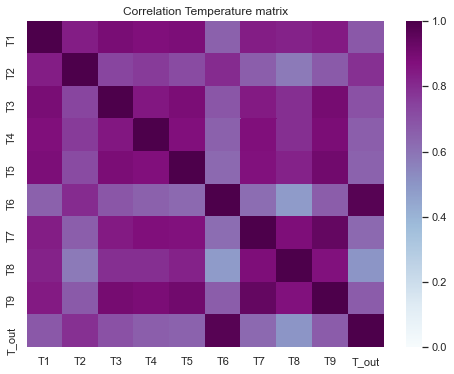

In [24]:
"""Let's see temperature correlation"""
plt.figure(figsize = (8,6))
sns.heatmap(df[['T1','T2','T3','T4','T5','T6','T7','T8','T9','T_out']].corr(), cmap="BuPu", vmin=0, vmax=1)
plt.title('Correlation Temperature matrix')
plt.show()

In [36]:
df = df.drop(['T2','T3','T4','T5','T7','T8','T9','T_out'], axis=1)   # I've just kept T1 & T6

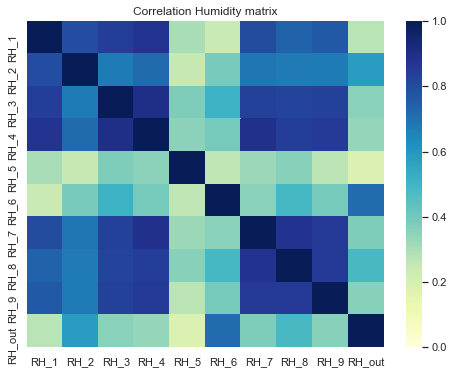

In [26]:
"""Let's check correlation between different humidities"""
plt.figure(figsize = (8,6))
sns.heatmap(df[['RH_1','RH_2','RH_3','RH_4','RH_5','RH_6','RH_7','RH_8','RH_9','RH_out']].corr(), cmap="YlGnBu", vmin=0, vmax=1)
plt.title('Correlation Humidity matrix')
plt.show()

In [37]:
df = df.drop(['RH_2','RH_3','RH_4','RH_6','RH_7','RH_8','RH_9'], axis=1)   # I've just kept RH_1, RH_5 & RH_out

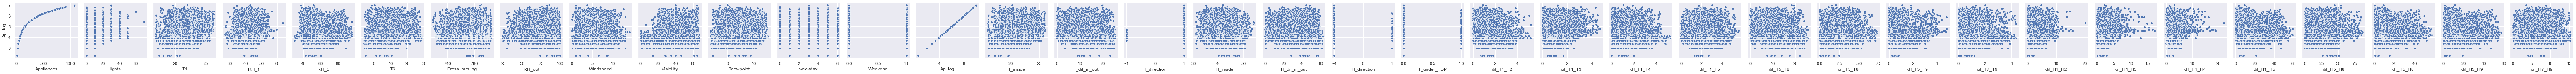

In [39]:
sns.pairplot(df, y_vars="Ap_log", x_vars=df.columns.values)

In [40]:
df.columns

Index(['Appliances', 'lights', 'T1', 'RH_1', 'RH_5', 'T6', 'Press_mm_hg',
       'RH_out', 'Windspeed', 'Visibility', 'Tdewpoint', 'weekday', 'Weekend',
       'Ap_log', 'T_inside', 'T_dif_in_out', 'T_direction', 'H_inside',
       'H_dif_in_out', 'H_direction', 'T_under_TDP', 'dif_T1_T2', 'dif_T1_T3',
       'dif_T1_T4', 'dif_T1_T5', 'dif_T5_T6', 'dif_T5_T8', 'dif_T5_T9',
       'dif_T7_T9', 'dif_H1_H2', 'dif_H1_H3', 'dif_H1_H4', 'dif_H1_H5',
       'dif_H5_H6', 'dif_H5_H8', 'dif_H5_H9', 'dif_H7_H9'],
      dtype='object')

In [30]:
# Model with all columns (before p-hacking) 
model=ols('Ap_log ~ lights + T1 + RH_1 + RH_5 + T6 + dif_T1_T2 + dif_T1_T3 + dif_T1_T4 + dif_T1_T5 + dif_T5_T6 + dif_T5_T8 + dif_T5_T9 + dif_T7_T9 + dif_H1_H2 + dif_H1_H3 + dif_H1_H4 + dif_H1_H5 + dif_H5_H8 + dif_H5_H6 + dif_H7_H9 + dif_H5_H9 + T_out + RH_out + T_inside + H_inside + T_dif_in_out + H_dif_in_out + T_direction + H_direction + Windspeed + Visibility + Press_mm_hg + Tdewpoint + T_under_TDP + weekday + Weekend', data=df)
model.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Ap_log   R-squared:                       0.282
Model:                            OLS   Adj. R-squared:                  0.281
Method:                 Least Squares   F-statistic:                     215.0
Date:                Mon, 05 Oct 2020   Prob (F-statistic):               0.00
Time:                        01:44:48   Log-Likelihood:                -16422.
No. Observations:               19735   AIC:                         3.292e+04
Df Residuals:                   19698   BIC:                         3.321e+04
Df Model:                          36                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        6.9979      0.621     11.263      0.000       5.780       8.216
lights           0.0182      0.001     33.726      0.000       0.017       0.019
T1               0.1420      0.023      6.245      0.000       0.097       0.187
RH_1            -0.0354      0.010     -3.656      0.000      -0.054      -0.016
RH_5             0.0530      0.008      6.272      0.000       0.036       0.070
T6              -0.0283      0.015     -1.840      0.066      -0.058       0.002
dif_T1_T2       -0.1772      0.008    -22.311      0.000      -0.193      -0.162
dif_T1_T3        0.1604      0.007     21.419      0.000       0.146       0.175
dif_T1_T4       -0.0001      0.008     -0.014      0.989      -0.016       0.015
dif_T1_T5       -0.0306      0.015     -2.057      0.040      -0.060      -0.001
dif_T5_T6        0.0660      0.011      5.946      0.000       0.044       0.088
dif_T5_T8        0.1247      0.007     18.672      0.000       0.112       0.138
dif_T5_T9        0.0007      0.008      0.095      0.925      -0.015       0.016
dif_T7_T9       -0.0095      0.008     -1.115      0.265      -0.026       0.007
dif_H1_H2        0.0486      0.004     13.141      0.000       0.041       0.056
dif_H1_H3        0.0230      0.004      5.933      0.000       0.015       0.031
dif_H1_H4        0.0349      0.004      9.719      0.000       0.028       0.042
dif_H1_H5       -0.0799      0.008    -10.443      0.000      -0.095      -0.065
dif_H5_H8        0.0258      0.002     10.404      0.000       0.021       0.031
dif_H5_H6        0.0016      0.000      5.076      0.000       0.001       0.002
dif_H7_H9     9.556e-05      0.003      0.034      0.973      -0.005       0.006
dif_H5_H9        0.0100      0.004      2.319      0.020       0.002       0.018
T_out           -0.0208      0.012     -1.699      0.089      -0.045       0.003
RH_out           0.0008      0.010      0.074      0.941      -0.019       0.021
T_inside        -0.0871      0.031     -2.839      0.005      -0.147      -0.027
H_inside        -0.0377      0.014     -2.690      0.007      -0.065      -0.010
T_dif_in_out    -0.1181      0.023     -5.130      0.000      -0.163      -0.073
H_dif_in_out    -0.0029      0.010     -0.295      0.768      -0.022       0.016
T_direction     -0.0273      0.063     -0.436      0.663      -0.150       0.095
H_direction     -0.1299      0.047     -2.782      0.005      -0.221      -0.038
Windspeed        0.0093      0.002      4.465      0.000       0.005       0.013
Visibility       0.0008      0.000      2.326      0.020       0.000       0.001
Press_mm_hg     -0.0034      0.001     -5.198      0.000      -0.005      -0.002
Tdewpoint        0.0015      0.012      0.124      0.901      -0.023       0.026
T_under_TDP     -0.0134      0.022     -0.602      0.547      -0.057       0.030
weekd

In [31]:
# Model after p-hacking
model=ols('Ap_log ~ lights + T1 + RH_1 + RH_5 + dif_T1_T2 + dif_T1_T3 + dif_T5_T6 + dif_T5_T8 + dif_H1_H2 + dif_H1_H3 + dif_H1_H4 + dif_H1_H5 + dif_H5_H6 + dif_H5_H8 + T_out + T_inside + H_inside + T_dif_in_out + H_direction + Windspeed + Press_mm_hg + Weekend', data=df)
model.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Ap_log   R-squared:                       0.280
Model:                            OLS   Adj. R-squared:                  0.280
Method:                 Least Squares   F-statistic:                     349.1
Date:                Mon, 05 Oct 2020   Prob (F-statistic):               0.00
Time:                        01:44:49   Log-Likelihood:                -16445.
No. Observations:               19735   AIC:                         3.294e+04
Df Residuals:                   19712   BIC:                         3.312e+04
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        6.9218      0.501     13.818      0.000       5.940       7.904
lights           0.0182      0.001     34.570      0.000       0.017       0.019
T1               0.1091      0.009     11.685      0.000       0.091       0.127
RH_1            -0.0210      0.008     -2.555      0.011      -0.037      -0.005
RH_5             0.0611      0.007      8.244      0.000       0.047       0.076
dif_T1_T2       -0.1767      0.007    -24.487      0.000      -0.191      -0.163
dif_T1_T3        0.1553      0.007     21.881      0.000       0.141       0.169
dif_T5_T6        0.0764      0.007     10.323      0.000       0.062       0.091
dif_T5_T8        0.1147      0.005     21.749      0.000       0.104       0.125
dif_H1_H2        0.0448      0.003     13.571      0.000       0.038       0.051
dif_H1_H3        0.0206      0.004      5.499      0.000       0.013       0.028
dif_H1_H4        0.0338      0.004      9.641      0.000       0.027       0.041
dif_H1_H5       -0.0741      0.007    -10.327      0.000      -0.088      -0.060
dif_H5_H6        0.0016      0.000      5.315      0.000       0.001       0.002
dif_H5_H8        0.0252      0.002     11.166      0.000       0.021       0.030
T_out           -0.0168      0.004     -4.539      0.000      -0.024      -0.010
T_inside        -0.0830      0.010     -8.444      0.000      -0.102      -0.064
H_inside        -0.0597      0.006     -9.621      0.000      -0.072      -0.048
T_dif_in_out    -0.0992      0.009    -11.509      0.000      -0.116      -0.082
H_direction     -0.1522      0.026     -5.815      0.000      -0.203      -0.101
Windspeed        0.0110      0.002      5.611      0.000       0.007       0.015
Press_mm_hg     -0.0035      0.001     -5.681      0.000      -0.005      -0.002
Weekend          0.0459      0.009      4.950      0.000       0.028       0.064
==============================================================================
Omnibus:                     4537.151   Durbin-Watson:                   0.518
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            10935.531
Skew:                           1.279   Prob(JB):                         0.00
Kurtosis:                       5.599   Cond. No.                     9.61e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.61e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Fitting linear regression

R^2: 0.27553344504849864 

Coefficients
-------------------------------------
Intercept: 4.303707375023424
lights: 0.15
Windspeed: 0.02
Press_mm_hg: -0.03
Weekend: 0.03
T1: 0.15
T_out: 0.02
T_inside: -0.16
dif_T1_T2: -0.15
dif_T1_T3: 0.1
dif_T5_T6: -0.01
dif_T5_T8: 0.09
RH_1: -0.11
RH_5: 0.6
dif_H1_H2: 0.08
dif_H1_H3: 0.04
dif_H1_H4: 0.05
dif_H1_H5: -0.68
dif_H5_H6: 0.03
dif_H5_H8: 0.21
H_inside: -0.24
H_dif_in_out: -0.0
H_direction: -0.02

Assumption 1: Linear Relationship between the Target and the Features
Checking with a scatter plot of actual vs. predicted. Predictions should follow the diagonal line.


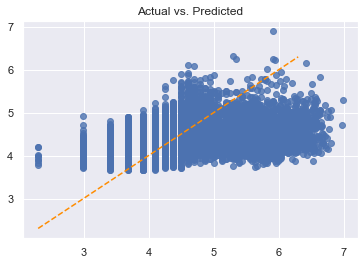

If non-linearity is apparent, consider adding a polynomial term 
		or using box-cox transformation to make X or y follow normal distribution



Building a correlation table


Parameters that are most likely VIOLATE linearity assumption and their correlation with Ap_log


Windspeed       0.087722
Press_mm_hg    -0.072632
T1              0.160747
T_out           0.176161
T_inside        0.155760
dif_T1_T2      -0.189770
dif_T1_T3       0.138188
dif_T5_T6      -0.194509
dif_T5_T8       0.104462
RH_1            0.084457
RH_5            0.024312
dif_H1_H2       0.071480
dif_H1_H3       0.224012
dif_H1_H4       0.222466
dif_H1_H5      -0.010977
dif_H5_H6       0.094819
dif_H5_H8       0.116941
H_inside       -0.053784
H_dif_in_out   -0.234099
Name: Ap_log, dtype: float64


Parameters that are most likely FOLLOW linearity assumption and their correlation with Ap_log


lights    0.261442
Name: Ap_log, dtype: float64


Assumption 2: Little to no multicollinearity among predictors


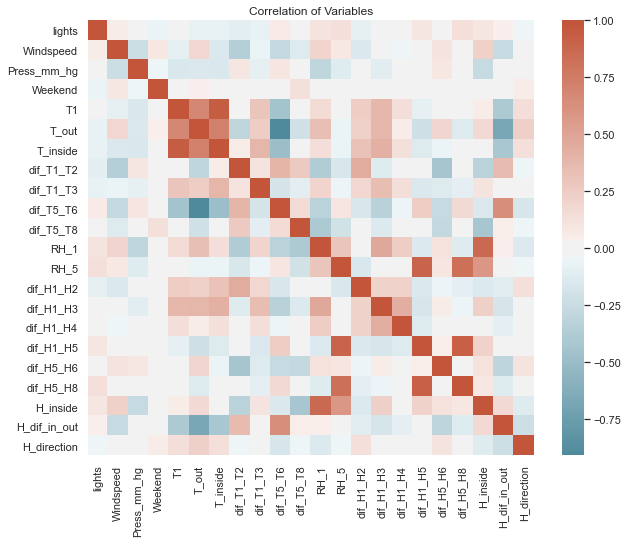

Variance Inflation Factors (VIF)
> 10: An indication that multicollinearity may be present
> 100: Certain multicollinearity among the variables
-------------------------------------
RH_5: 283.4135889542496
dif_H1_H5: 243.05563797029274
RH_1: 67.88235553466211
H_inside: 39.91146184345947
dif_H5_H8: 22.6816436596399
T_out: 22.29813646549412
T_inside: 20.172681062481043
T1: 13.977704938596789
dif_T5_T6: 11.3344096578739
H_dif_in_out: 3.6429063922433715
dif_T1_T2: 2.883045506486659
dif_H1_H3: 2.1465861142946663
dif_H1_H2: 1.893595087683329
dif_H1_H4: 1.7854043855816495
Windspeed: 1.5465526542310752
dif_T5_T8: 1.515511645156736
dif_H5_H6: 1.4851413707693215
dif_T1_T3: 1.4546288347690213
H_direction: 1.2688029115501298
Press_mm_hg: 1.266271542091877
lights: 1.1186973165943805
Weekend: 1.0792570199198377

9 cases of possible multicollinearity
2 cases of definite multicollinearity

Assumption not satisfied

Coefficient interpretability will be problematic
Consider removing variables with a hig

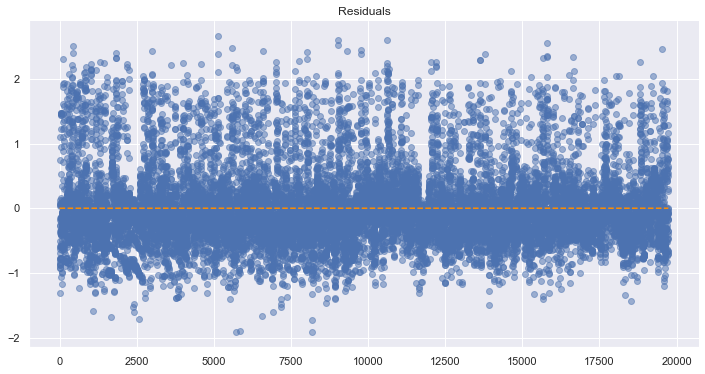

If heteroskedasticity is apparent, confidence intervals and predictions will be affected

Consider removing outliers and preprocessing features - nonlinear transformation can help


{'Lagrange Multiplier': 772.2349267166613,
 'pvalue for LM': 6.943916222502342e-150,
 'F stats': 36.490332145737916,
 'pvalue for Fstats': 2.811357294916184e-152}

Signs of positive autocorrelation 

Assumption potentially not satisfied 


Assumption 5: The error terms are kinda normally distributed

Using the Anderson-Darling test for normal distribution
p-value from the test - below 0.05 generally means non-normal: 0.0
Residuals are not normally distributed


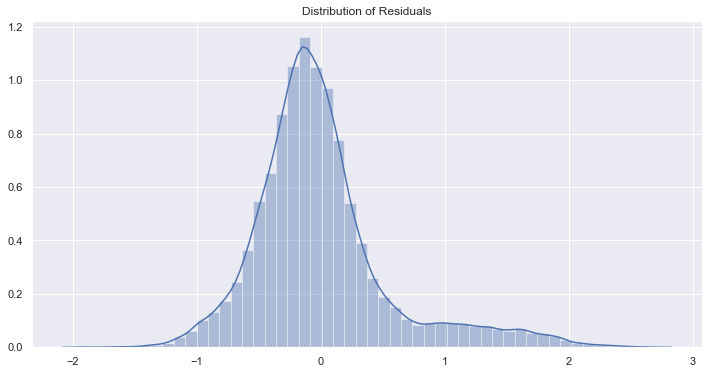


Assumption not satisfied

Confidence intervals will likely be affected
Try performing nonlinear transformations on variables
Building a probability plot


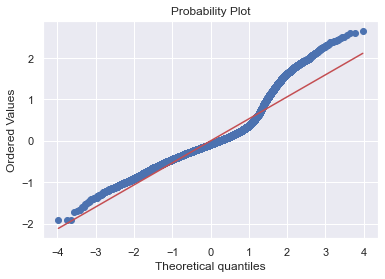


In your dataset you quite fat tails. You have 0.018 potential outliers (357 rows)


{'Satisfied': [],
 'Potentially': ['Linearity', 'Autocorrelation', 'Sub-Normality'],
 'Violated': ['Multicollinearity', 'Autocorrelation', 'Normality']}

In [32]:
# Testing Assumptions, just after p-hacking

df2=df[['Ap_log', 'lights', 'Windspeed', 'Press_mm_hg', 'Weekend',
        #'date','Appliances','RH_out',
        #'T2','RH_2','T3','RH_3','T4','RH_4','T5','T6','RH_6','T7','RH_7','T8','RH_8','T9','RH_9',
        #'dif_T1_T4', 'dif_T1_T5','dif_T5_T9','dif_T7_T9','dif_H7_H9', 'T_dif_in_out','Tdewpoint','T_under_TDP','Visibility',
        'T1','T_out','T_inside','dif_T1_T2','dif_T1_T3','dif_T5_T6', 'dif_T5_T8',
        'RH_1','RH_5','dif_H1_H2', 'dif_H1_H3', 'dif_H1_H4', 'dif_H1_H5','dif_H5_H6', 'dif_H5_H8',
        'H_inside','H_dif_in_out','H_direction']]

y=df.Ap_log
X=df2.drop('Ap_log', axis=1)

ast((X-X.mean())/X.std(),y).run_all()

Fitting linear regression

R^2: 0.2271956350534342 

Coefficients
-------------------------------------
Intercept: 4.303707375023304
lights: 0.16
T_inside: 0.03
Windspeed: 0.02
Press_mm_hg: -0.01
Weekend: 0.01
dif_T1_T2: -0.15
dif_T1_T3: 0.08
dif_T5_T6: -0.03
dif_T5_T8: 0.14
dif_H1_H2: 0.08
dif_H1_H3: 0.04
dif_H1_H4: 0.09
dif_H1_H5: 0.03
dif_H5_H6: 0.03

Assumption 1: Linear Relationship between the Target and the Features
Checking with a scatter plot of actual vs. predicted. Predictions should follow the diagonal line.


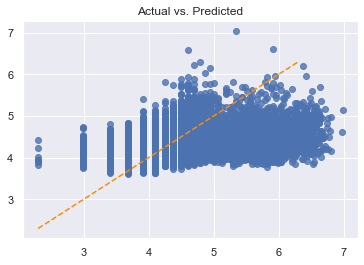

If non-linearity is apparent, consider adding a polynomial term 
		or using box-cox transformation to make X or y follow normal distribution



Building a correlation table


Parameters that are most likely VIOLATE linearity assumption and their correlation with Ap_log


T_inside       0.155760
Windspeed      0.087722
Press_mm_hg   -0.072632
dif_T1_T2     -0.189770
dif_T1_T3      0.138188
dif_T5_T6     -0.194509
dif_T5_T8      0.104462
dif_H1_H2      0.071480
dif_H1_H3      0.224012
dif_H1_H4      0.222466
dif_H1_H5     -0.010977
dif_H5_H6      0.094819
Name: Ap_log, dtype: float64


Parameters that are most likely FOLLOW linearity assumption and their correlation with Ap_log


lights    0.261442
Name: Ap_log, dtype: float64


Assumption 2: Little to no multicollinearity among predictors


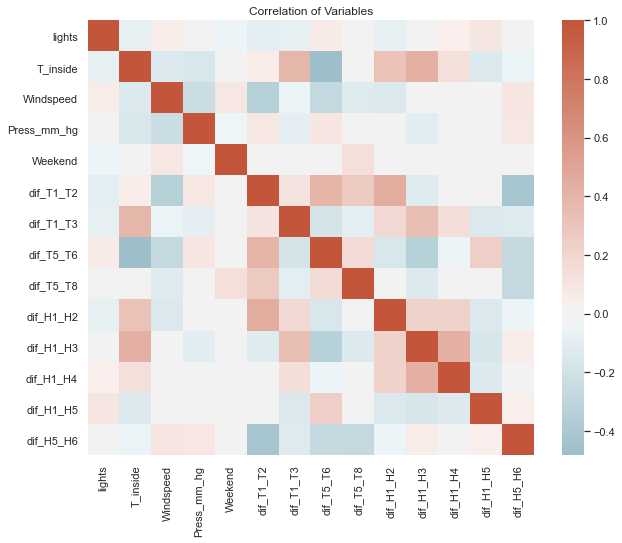

Variance Inflation Factors (VIF)
> 10: An indication that multicollinearity may be present
> 100: Certain multicollinearity among the variables
-------------------------------------
dif_T1_T2: 2.377317552746334
dif_T5_T6: 2.229055524391593
T_inside: 1.95162822969618
dif_H1_H2: 1.712124702012931
dif_H1_H3: 1.6672890966049199
dif_H5_H6: 1.4108967414270481
Windspeed: 1.3688256753564476
dif_H1_H4: 1.3206414337076853
dif_T1_T3: 1.3170891685697748
dif_T5_T8: 1.2061704821309973
dif_H1_H5: 1.136257351113794
Press_mm_hg: 1.1348645228030236
Weekend: 1.0446055839692656
lights: 1.043366276245259

0 cases of possible multicollinearity
0 cases of definite multicollinearity

Assumption satisfied

Assumption 3: No Autocorrelation

Performing Durbin-Watson Test
Values of 1.5 < d < 2.5 generally show that there is no autocorrelation in the data
0 to 2< is positive autocorrelation
>2 to 4 is negative autocorrelation
-------------------------------------
Durbin-Watson: 0.49218424373180886
Signs of positiv

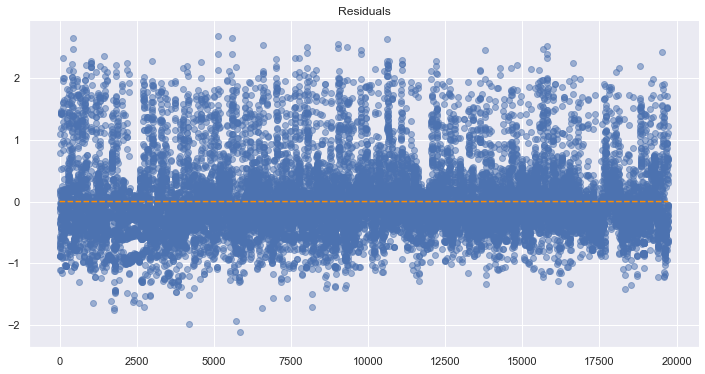

If heteroskedasticity is apparent, confidence intervals and predictions will be affected

Consider removing outliers and preprocessing features - nonlinear transformation can help


{'Lagrange Multiplier': 582.912501013151,
 'pvalue for LM': 3.3599867342753774e-116,
 'F stats': 42.87342207134816,
 'pvalue for Fstats': 3.50121760717751e-117}

Signs of positive autocorrelation 

Assumption potentially not satisfied 


Assumption 5: The error terms are kinda normally distributed

Using the Anderson-Darling test for normal distribution
p-value from the test - below 0.05 generally means non-normal: 0.0
Residuals are not normally distributed


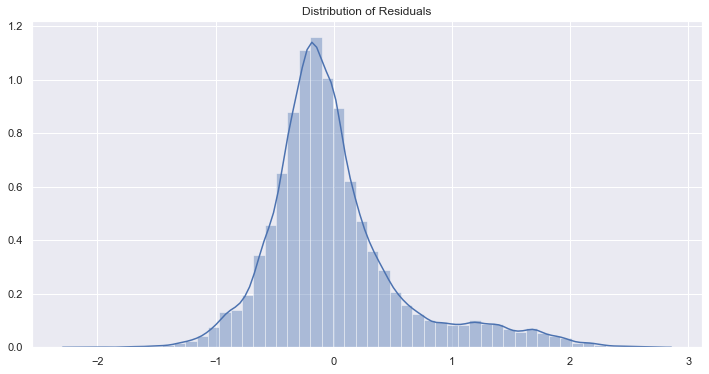


Assumption not satisfied

Confidence intervals will likely be affected
Try performing nonlinear transformations on variables
Building a probability plot


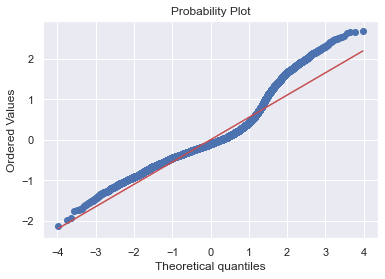

Assumption can be considered as satisfied.


{'Satisfied': ['Multicollinearity', 'Sub-Normality'],
 'Potentially': ['Linearity', 'Autocorrelation'],
 'Violated': ['Autocorrelation', 'Normality']}

In [33]:
# Testing Assumptions, after removing problematic columns

df3=df[['Ap_log', 'lights', 'T_inside', 'Windspeed', 'Press_mm_hg', 'Weekend',
        #'date','Appliances','RH_out','T_out', 'T_inside','T1','RH_1',  
        #'T2','RH_2','T3','RH_3','T4','RH_4','T5','RH_5','T6','RH_6','T7','RH_7','T8','RH_8','T9','RH_9',
        #'dif_T1_T4', 'dif_T1_T5','dif_T5_T9','dif_T7_T9','dif_H5_H8','dif_H7_H9',
        #'H_inside','T_dif_in_out','Tdewpoint','T_under_TDP','Visibility','H_direction', 'H_dif_in_out',
        'dif_T1_T2','dif_T1_T3','dif_T5_T6', 'dif_T5_T8',
        'dif_H1_H2','dif_H1_H3','dif_H1_H4','dif_H1_H5','dif_H5_H6']]

y=df.Ap_log
X=df3.drop('Ap_log', axis=1)

ast((X-X.mean())/X.std(),y).run_all()

In [ ]:
BACK TO PRESENTATION

In [41]:
"""Random Forest Regression"""
from sklearn.ensemble import RandomForestRegressor
rf=RandomForestRegressor()
rf.fit(X,y)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

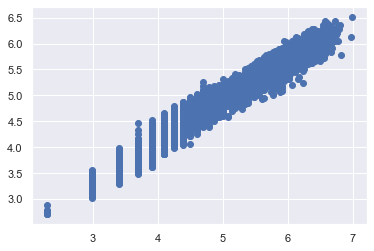

In [42]:
plt.scatter(y,rf.predict(X))

In [ ]:
"""K-neighbors regression"""
from sklearn.neighbors import KNeighborsRegressor
neigh = KNeighborsRegressor(n_neighbors=2)
neigh.fit(X, y)

In [ ]:
"""train_test_split"""
from sklearn.model_selection import train_test_split
train, test = train_test_split(df3, test_size=0.2)
train, test

In [ ]:
"""RMSE"""
def rmse(predictions, targets):
    return np.sqrt(np.mean((predictions-targets)**2))